<a href="https://colab.research.google.com/github/cancan-lab/Notebook-DM2/blob/main/DM2_Image_Clustering_RGB_aja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining 2 — Image Clustering
Notebook ini menyiapkan pipeline **unsupervised clustering** untuk data gambar tanpa label.
Model fitur yang dipakai: **MobileNetV2 (ImageNet)** → embedding → **PCA/UMAP** → **KMeans/Agglomerative/DBSCAN**.

➡️ **Isi laporan** yang bisa kamu ambil dari notebook ini:
- Plot distribusi & grid sampel
- Visualisasi 2D (UMAP) berwarna per cluster
- Metrik: Silhouette, Calinski-Harabasz, Davies-Bouldin
- Tabel ringkasan cluster + contoh gambar per cluster
- CSV mapping `filename → cluster`

> Catatan: Jalankan cell **berurutan dari atas**. Pastikan runtime GPU (opsional).

## 0) Setup & Paths

In [2]:
#@title Paths & Config
from pathlib import Path
import os, zipfile, random, shutil, math

# === Ganti ini jika perlu ===
DATA_ZIP_PATH = "/content/train-20250930T032844Z-1-001.zip"  #@param {type:"string"}
EXTRACT_DIR = "/content/uts_dm2_image_dataset"  #@param {type:"string"}
IMAGE_DIR_NAME = "train"  #@param {type:"string"}

# === Opsi: Jika kamu sudah ekstrak manual, set SKIP_UNZIP=True ===
SKIP_UNZIP = False  #@param {type:"boolean"}

# Buat folder kerja
os.makedirs(EXTRACT_DIR, exist_ok=True)

if not SKIP_UNZIP:
    assert os.path.exists(DATA_ZIP_PATH), f"ZIP tidak ditemukan: {DATA_ZIP_PATH}"
    with zipfile.ZipFile(DATA_ZIP_PATH, 'r') as zf:
        zf.extractall(EXTRACT_DIR)

DATA_DIR = Path(EXTRACT_DIR) / IMAGE_DIR_NAME
assert DATA_DIR.exists(), f"Folder data tidak ada: {DATA_DIR}"
print("Data dir:", DATA_DIR)

# List file gambar
IMG_EXTS = (".png",".jpg",".jpeg",".bmp",".tif",".tiff",".webp",".gif")
all_images = [p for p in DATA_DIR.rglob("*") if p.suffix.lower() in IMG_EXTS]
print(f"Total images found: {len(all_images)}")
assert len(all_images) > 0, "Tidak ada gambar ditemukan!"

# Buat output dir
OUT_DIR = Path("/content/uts_dm2_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Output dir:", OUT_DIR)

Data dir: /content/uts_dm2_image_dataset/train
Total images found: 173
Output dir: /content/uts_dm2_outputs


## 1) Exploratory Data Analysis (EDA)

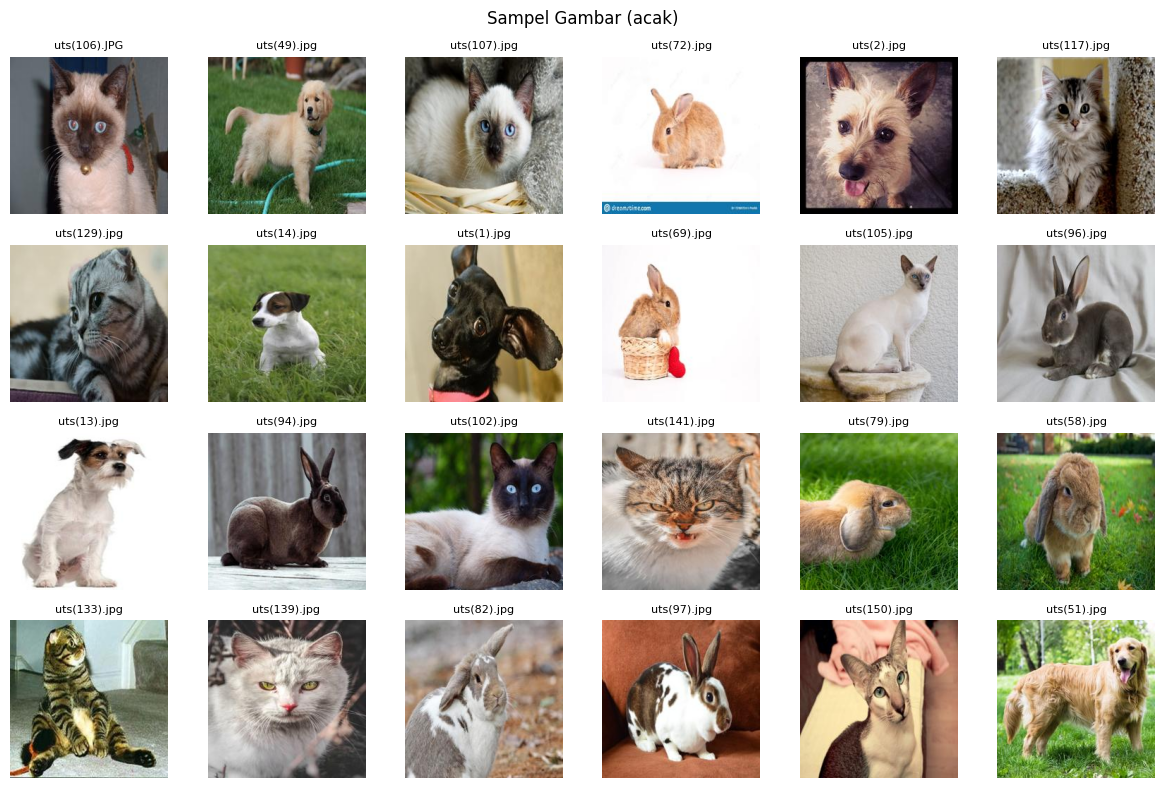

In [3]:
import PIL.Image as Image
import matplotlib.pyplot as plt
import numpy as np

def plot_image_grid(paths, cols=6, max_images=30, figsize=(12,8), title=None):
    paths = paths[:max_images]
    rows = math.ceil(len(paths)/cols)
    plt.figure(figsize=figsize)
    for i,p in enumerate(paths,1):
        try:
            img = Image.open(p).convert("RGB")
        except Exception as e:
            print("Skip:", p, e); continue
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(p.name, fontsize=8)
    if title:
        plt.suptitle(title, y=0.98)
    plt.tight_layout()
    plt.show()

sample_paths = random.sample(all_images, k=min(24, len(all_images)))
plot_image_grid(sample_paths, cols=6, max_images=24, title="Sampel Gambar (acak)")

## 2) Feature Extraction — MobileNetV2 (ImageNet)
Alasan: ringan, cepat, dan embedding cukup representatif untuk clustering visual.

In [4]:
# Install (Colab biasanya sudah punya)
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
from tqdm import tqdm

IMG_SIZE = 224  # ukuran input MobileNetV2
BATCH = 32

# Model tanpa top, pakai global average pooling => vektor 1280 dim
base_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")
base_model.trainable = False

def load_and_preprocess(paths):
    batch = np.zeros((len(paths), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
    for i,p in enumerate(paths):
        img = image.load_img(p, target_size=(IMG_SIZE, IMG_SIZE))
        x = image.img_to_array(img)
        batch[i] = preprocess_input(x)
    return batch

# Ekstraksi embedding per batch
embeddings = []
filenames = [str(p) for p in all_images]
for i in tqdm(range(0, len(filenames), BATCH)):
    batch_paths = filenames[i:i+BATCH]
    batch = load_and_preprocess(batch_paths)
    emb = base_model.predict(batch, verbose=0)
    embeddings.append(emb)
embeddings = np.vstack(embeddings)
print("Embeddings shape:", embeddings.shape)  # (N, 1280)

/tmp/ipython-input-3110782482.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 6/6 [00:08<00:00,  1.49s/it]

Embeddings shape: (173, 1280)


## 3) Dimensionality Reduction (PCA → UMAP 2D)

In [5]:
from sklearn.decomposition import PCA
import numpy as np

# PCA ke 50 dim untuk kompresi & denoise
pca = PCA(n_components=min(50, embeddings.shape[1]))
X_pca = pca.fit_transform(embeddings)
print("Explained variance (50 dim):", round(pca.explained_variance_ratio_.sum(), 4))

Explained variance (50 dim): 0.7731


In [6]:
# UMAP untuk visualisasi 2D (jika belum terpasang, uncomment install)
# !pip install umap-learn -q
import umap
um = umap.UMAP(n_neighbors=15, min_dist=0.0, n_components=2, random_state=42)
X_umap = um.fit_transform(X_pca)
print("UMAP shape:", X_umap.shape)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP shape: (173, 2)


## 4) Clustering — KMeans (pilih k terbaik dengan Silhouette)
Kita coba k=2..10 dan pilih skor Silhouette tertinggi.

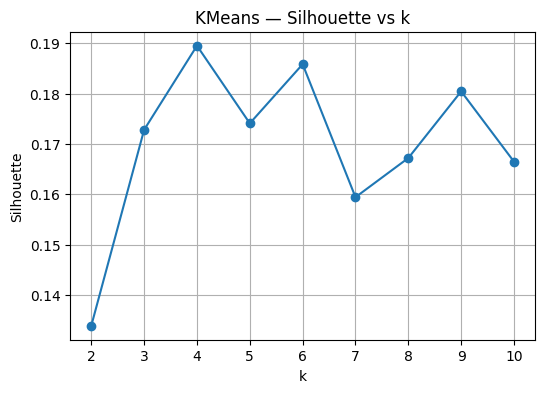

Best k (KMeans): 4
KMeans(k=4): Silhouette=0.190 | Calinski-Harabasz=21.9 | Davies-Bouldin=2.030


In [7]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt

def try_kmeans(X, k_range=range(2,11)):
    scores = []
    models = {}
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels)
        scores.append((k, sil))
        models[k] = (km, labels)
    return scores, models

scores, km_models = try_kmeans(X_pca, range(2,11))
ks = [k for k,_ in scores]
sils = [s for _,s in scores]

plt.figure(figsize=(6,4))
plt.plot(ks, sils, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.title("KMeans — Silhouette vs k")
plt.grid(True); plt.show()

best_k = ks[int(np.argmax(sils))]
km_best, labels_km = km_models[best_k]
print("Best k (KMeans):", best_k)

def print_cluster_metrics(X, labels, name="Model"):
    sil = silhouette_score(X, labels)
    ch  = calinski_harabasz_score(X, labels)
    db  = davies_bouldin_score(X, labels)
    print(f"{name}: Silhouette={sil:.3f} | Calinski-Harabasz={ch:.1f} | Davies-Bouldin={db:.3f}")

print_cluster_metrics(X_pca, labels_km, name=f"KMeans(k={best_k})")

**Interpretasi**

Proses penentuan jumlah cluster dilakukan dengan menguji KMeans pada rentang k = 2–10 dan mengevaluasi menggunakan Silhouette. Nilai tertinggi diperoleh pada k = 4 (Silhouette = 0,190), sehingga k = 4 dipilih sebagai konfigurasi akhir. Evaluasi tambahan menunjukkan Calinski-Harabasz sebesar 21,9 dan Davies-Bouldin 2,03. Kombinasi metrik ini menandakan pemisahan antarkelompok yang masih lemah dan adanya tumpang tindih antar anggota cluster.

### Agglomerative (opsional pembanding)

In [8]:
agg = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
labels_agg = agg.fit_predict(X_pca)
print_cluster_metrics(X_pca, labels_agg, name=f"Agglomerative(k={best_k}, ward)")

Agglomerative(k=4, ward): Silhouette=0.152 | Calinski-Harabasz=21.1 | Davies-Bouldin=2.084


**Interpretasi**

Sebagai pembanding, dilakukan hierarchical clustering dengan Agglomerative linkage Ward (k=4). Hasil evaluasi menunjukkan Silhouette 0,152, Calinski–Harabasz 21,1, dan Davies–Bouldin 2,084. Nilai-nilai ini lebih rendah/kurang baik daripada KMeans(k=4) (Silhouette 0,190; CH 21,9; DB 2,03), yang menandakan pemisahan cluster pada Agglomerative lebih lemah dan kemiripan antar cluster lebih tinggi.

### DBSCAN (opsional)

In [9]:
# Hyperparam default: eps dan min_samples perlu coba-coba
db = DBSCAN(eps=1.5, min_samples=5)
labels_db = db.fit_predict(X_pca)
n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
print("DBSCAN clusters (tanpa noise):", n_clusters_db, "| noise:", (labels_db == -1).sum())
if n_clusters_db >= 2:
    print_cluster_metrics(X_pca, labels_db[labels_db!=-1], name="DBSCAN (subset tanpa noise)")

DBSCAN clusters (tanpa noise): 0 | noise: 173


**Interpretasi**

DBSCAN dengan parameter awal (eps=1.5, min_samples=5) tidak membentuk cluster (seluruh 173 sampel diklasifikasikan sebagai noise). Hal ini mengindikasikan tidak ditemukan kepadatan lokal yang memadai pada skala jarak tersebut di ruang PCA. Mengingat sensitivitas DBSCAN terhadap skala dan pilihan metrik, serta struktur data yang cenderung tumpang-tindih, pendekatan density-based kurang cocok sebagai model utama untuk dataset ini.

## 5) Visualisasi 2D (UMAP)

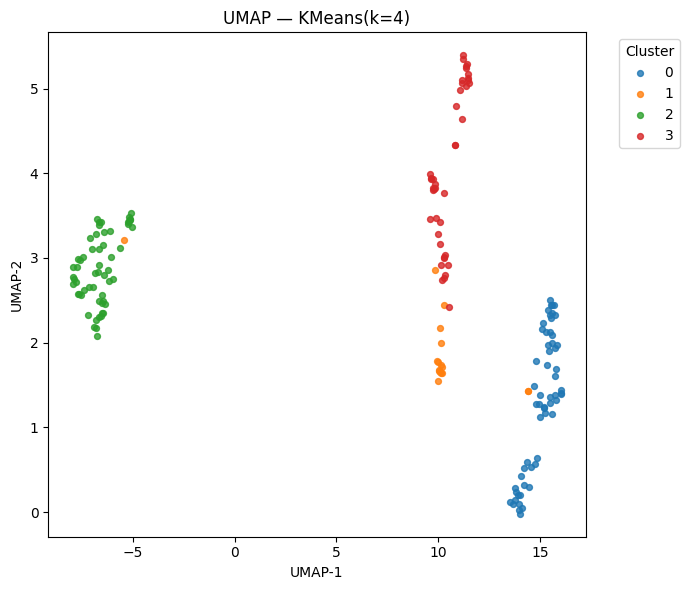

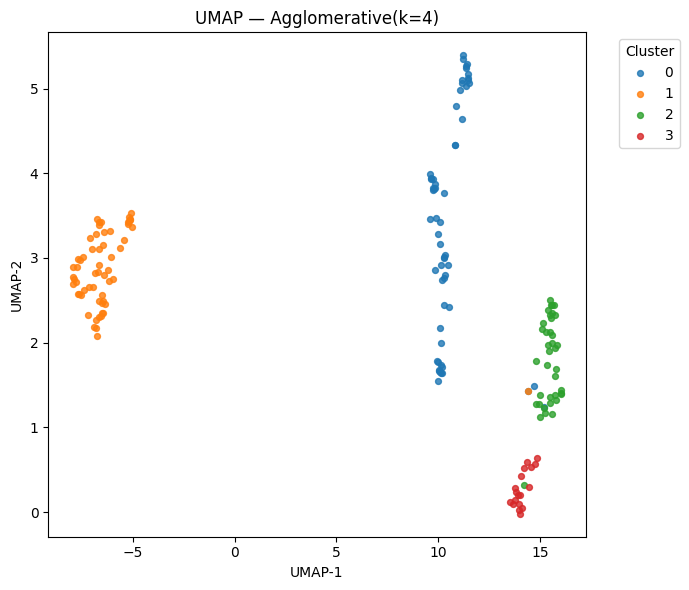

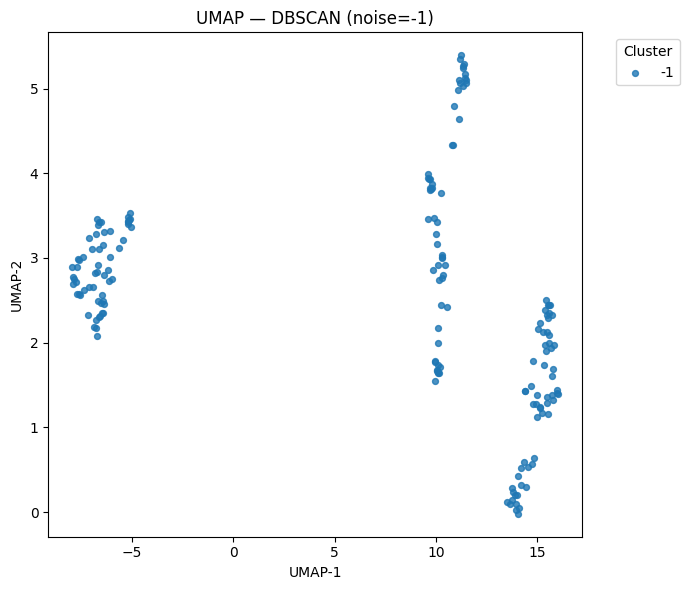

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def scatter_by_labels(X2d, labels, title):
    plt.figure(figsize=(7,6))
    uniq = sorted(set(labels))
    for u in uniq:
        mask = labels == u
        plt.scatter(X2d[mask,0], X2d[mask,1], s=18, label=str(u), alpha=0.8)
    plt.legend(title="Cluster", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.title(title)
    plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()

scatter_by_labels(X_umap, labels_km, f"UMAP — KMeans(k={best_k})")
scatter_by_labels(X_umap, labels_agg, f"UMAP — Agglomerative(k={best_k})")
if 'labels_db' in globals():
    scatter_by_labels(X_umap, labels_db, "UMAP — DBSCAN (noise=-1)")

**Interpretasi**

Visualisasi UMAP mengonfirmasi pembentukan empat kelompok utama. Pada KMeans(k=4), satu gugus di sisi kiri terlihat paling kompak, sementara dua gugus di kanan cenderung memanjang dan salah satunya memperlihatkan dua pita kecil (indikasi sub-cluster). Sebagian sampel berposisi di area perbatasan antara gugus tengah-kanan, sehingga wajar jika metrik Silhouette relatif rendah (0,190). Pada Agglomerative (ward, k=4), pola makro tetap sama, namun pembagian batas lebih “mengikat” area memanjang menjadi satu kelompok besar, menghasilkan Silhouette yang lebih rendah (0,152). DBSCAN tidak menemukan cluster pada parameter awal (seluruh sampel dianggap noise), menunjukkan bahwa pada skala jarak tersebut tidak terdapat kepadatan lokal yang memadai. Secara keseluruhan, KMeans memberikan pemisahan paling stabil untuk interpretasi deskriptif pola visual pada dataset ini.

## 6) Ringkasan Cluster & Contoh Gambar

In [11]:
import pandas as pd, numpy as np, os, shutil, PIL.Image as Image, matplotlib.pyplot as plt

df = pd.DataFrame({
    "filepath": filenames,
    "cluster_kmeans": labels_km,
    "x": X_umap[:,0],
    "y": X_umap[:,1]
})
df.to_csv(OUT_DIR / "clusters_kmeans.csv", index=False)
print("Saved:", OUT_DIR / "clusters_kmeans.csv")

# Hitung jarak ke centroid untuk contoh representatif
centers = km_best.cluster_centers_
from sklearn.metrics import pairwise_distances
dists = pairwise_distances(X_pca, centers, metric='euclidean')
df['dist_to_centroid'] = dists.min(axis=1)

summary = df.groupby("cluster_kmeans").agg(
    n=("filepath","count"),
    med_dist=("dist_to_centroid","median"),
    min_dist=("dist_to_centroid","min"),
).reset_index().sort_values("cluster_kmeans")
summary

Saved: /content/uts_dm2_outputs/clusters_kmeans.csv


cluster_kmeans   n   med_dist   min_dist
0               0  58  10.429632   6.723763
1               1  17  11.213202   7.110317
2               2  57  11.254382   7.317601
3               3  41  12.928800  10.625000

**Interpretasi**

Empat cluster yang terbentuk relatif tidak seimbang: dua cluster besar (C0=33,5% dan C2=32,9%), satu cluster sedang (C3=23,7%), dan satu cluster kecil (C1=9,8%). Berdasarkan median jarak ke centroid, C0 merupakan cluster paling kompak, sedangkan C3 merupakan paling longgar. Nilai minimum jarak di C3 juga tertinggi (10,63), yang menandakan centroidnya kurang merepresentasikan seluruh anggota karena bentuk cluster yang memanjang/heterogen. Pola ini sesuai dengan visualisasi UMAP: satu gugus kiri (kompak), gugus tengah-kanan yang memanjang, dan satu gugus kecil di antara keduanya. Dengan demikian, interpretasi hasil lebih tepat bersifat deskriptif (kemiripan visual) ketimbang kategorisasi yang tegas.

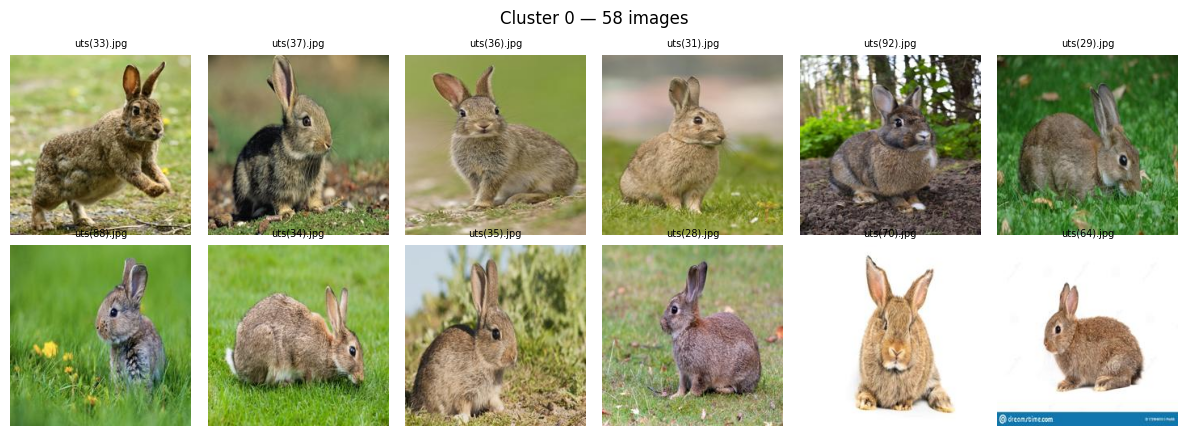

Saved grid: /content/uts_dm2_outputs/examples/cluster_0_grid.png


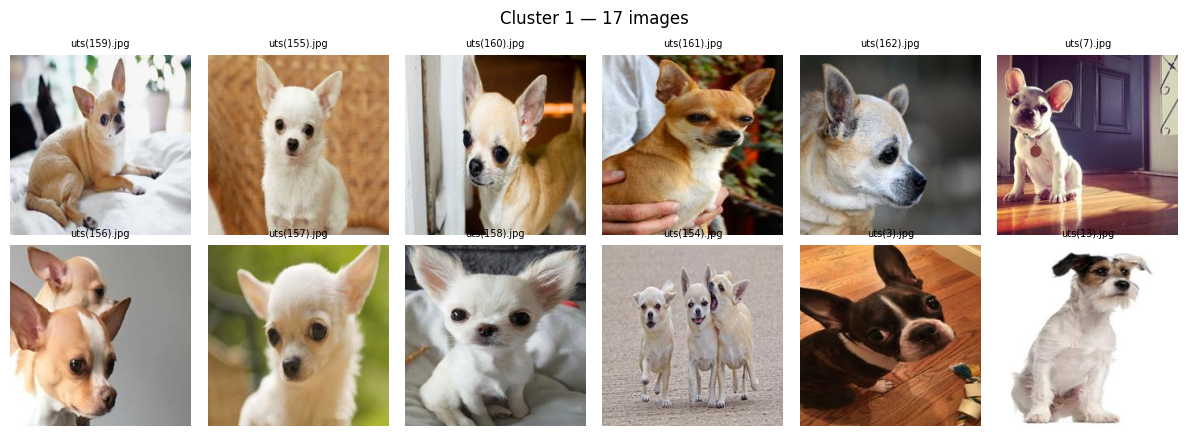

Saved grid: /content/uts_dm2_outputs/examples/cluster_1_grid.png


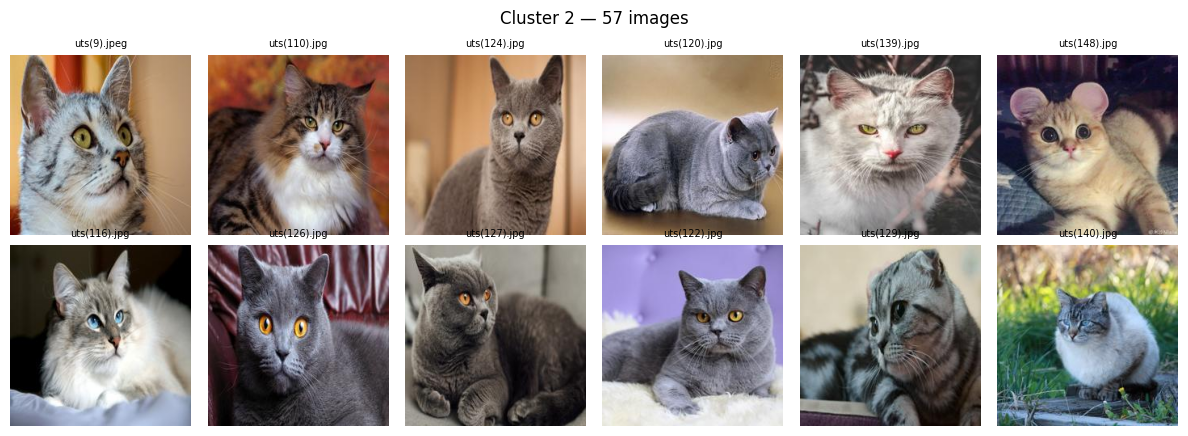

Saved grid: /content/uts_dm2_outputs/examples/cluster_2_grid.png


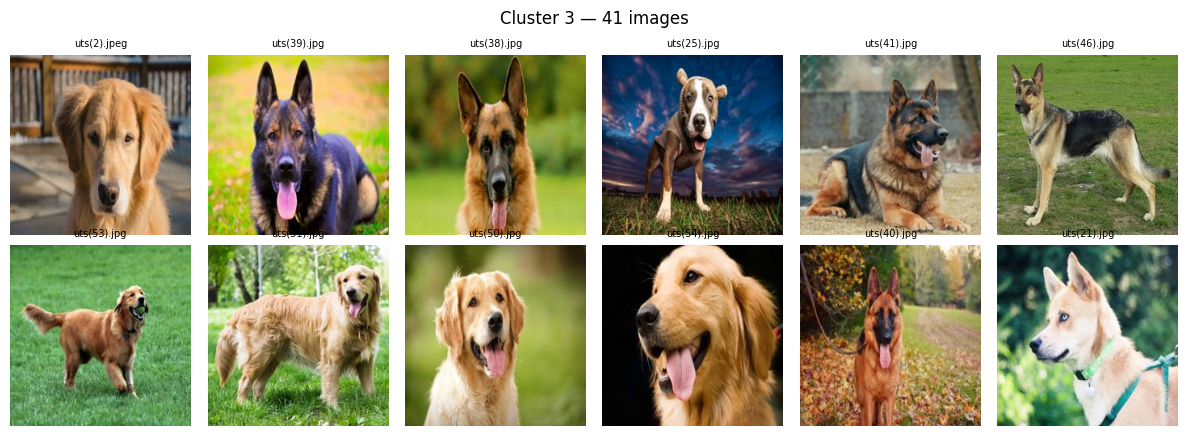

Saved grid: /content/uts_dm2_outputs/examples/cluster_3_grid.png


In [12]:
# Simpan contoh gambar per cluster
def save_cluster_examples(df, out_dir, n_per_cluster=12, cols=6):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    for c, sub in df.sort_values("dist_to_centroid").groupby("cluster_kmeans"):
        sel = sub.head(n_per_cluster)
        # grid plot
        paths = sel["filepath"].tolist()
        rows = math.ceil(len(paths)/cols)
        plt.figure(figsize=(12, rows*2.2))
        for i,p in enumerate(paths,1):
            img = Image.open(p).convert("RGB")
            plt.subplot(rows, cols, i)
            plt.imshow(img); plt.axis("off")
            plt.title(Path(p).name, fontsize=7)
        plt.suptitle(f"Cluster {c} — {len(sub)} images", y=0.98)
        plt.tight_layout()
        fig_path = out_dir / f"cluster_{c}_grid.png"
        plt.savefig(fig_path, dpi=150); plt.show()
        print("Saved grid:", fig_path)

        # copy ke folder khusus
        tgt = out_dir / f"cluster_{c}_files"
        tgt.mkdir(exist_ok=True)
        for p in paths:
            shutil.copy2(p, tgt / Path(p).name)

save_cluster_examples(df, OUT_DIR / "examples", n_per_cluster=12, cols=6)

**Interpretasi**

1. Cluster 0 — Kelinci / outdoor hijau (n = 58, median dist 10.43)

* Ciri visual dominan: hewan kecil bertelinga panjang (kelinci), warna bulu coklat/abu netral, banyak di rumput/hijau dengan latar agak blur (bokeh). Mayoritas medium shot (setengah badan); beberapa studio background putih sebagai outlier kecil.

* Alasan terkumpul: kemiripan bentuk telinga/wajah, tekstur bulu halus, dan konteks latar hijau yang konsisten tertangkap kuat oleh embedding MobileNetV2.

* Kualitas cluster: paling kompak di ringkasan jarak (median terkecil) → selaras dengan UMAP yang memperlihatkan gugus rapat. Cocok dijadikan representatif untuk pola kelas “kelinci/outdoor”.


2. Cluster 1 — Anjing kecil (Chihuahua & sejenis) / indoor (n = 17, median dist 11.21)

* Ciri visual dominan: anjing kecil bertelinga runcing, proporsi kepala besar, banyak close-up portrait, tone hangat (pencahayaan dalam ruangan, kayu/lantai).

* Alasan terkumpul: kemiripan morfologi (ukuran tubuh/proporsi wajah) dan konteks indoor; ini menjadikannya cluster niche (ukuran kecil).

* Kualitas cluster: relatif rapi meski kecil. Pada UMAP posisinya dekat dengan dua gugus lain → wajar jika beberapa sampel tampak borderline/ambang.

3. Cluster 2 — Kucing (ragam abu/loreng) / close-up (n = 57, median dist 11.25)

* Ciri visual dominan: kucing dengan variasi bulu abu/loreng; banyak close-up wajah dengan mata kontras (kuning/biru), latar indoor/outdoor yang blur.

* Alasan terkumpul: bentuk wajah/lingkar mata, tekstur kumis & bulu, serta komposisi close-up yang seragam → fitur CNN mengenali pola ini kuat.

* Kualitas cluster: hampir setara C0 dalam ukuran dan kerapatan → menandakan tema besar kedua di dataset.

4. Cluster 3 — Anjing besar (German Shepherd/Golden) / outdoor (n = 41, median dist 12.93 – paling besar)

* Ciri visual dominan: anjing besar (german shepherd, golden retriever, husky/jenis serupa), full-body atau setengah badan, latar rumput/alam; variasi pose & jarak cukup tinggi.

* Alasan terkumpul: kemiripan ukuran tubuh/moncong, tekstur bulu, dan konteks outdoor. Namun terdapat dua sub-tema yang cukup berbeda (shepherd vs golden) → membuat bentuk gugus memanjang di UMAP.

* Kualitas cluster: paling heterogen (median & min dist tertinggi) → centroid kurang mewakili seluruh anggota; konsisten dengan gugus vertikal memanjang pada UMAP.

## 7) (Opsional) Evaluasi Alternatif: Coba k lain & bandingkan metrik

In [13]:
def eval_many_k(X, ks):
    rows = []
    for k in ks:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels)
        ch  = calinski_harabasz_score(X, labels)
        db  = davies_bouldin_score(X, labels)
        rows.append(dict(k=k, silhouette=sil, calinski=ch, davies=db))
    return pd.DataFrame(rows).sort_values("silhouette", ascending=False)

eval_table = eval_many_k(X_pca, ks=list(range(2,11)))
eval_table

k  silhouette   calinski    davies
2   4    0.189529  21.872438  2.030064
4   6    0.185853  18.338409  2.009282
7   9    0.180454  15.482058  1.917375
3   5    0.174100  19.891657  2.048348
1   3    0.172819  26.014395  2.180119
6   8    0.167209  15.820581  2.174166
8  10    0.166476  14.351515  2.122597
5   7    0.159418  16.786669  2.226438
0   2    0.133870  25.738235  2.329988

## 8) Export & Kesimpulan Singkat
- Kamu bisa ambil **cluster grid** dan **plot UMAP** untuk laporan.
- Gunakan tabel metrik untuk menjelaskan pemilihan `k`.
- Lihat contoh gambar per cluster untuk interpretasi deskriptif.

In [14]:
from IPython.display import FileLink, display

print("Folder output:", OUT_DIR)
for p in sorted(OUT_DIR.rglob("*")):
    if p.is_file() and p.suffix.lower() in {".png",".csv"}:
        display(FileLink(str(p)))

Folder output: /content/uts_dm2_outputs


/content/uts_dm2_outputs/clusters_kmeans.csv

/content/uts_dm2_outputs/examples/cluster_0_grid.png

/content/uts_dm2_outputs/examples/cluster_1_grid.png

/content/uts_dm2_outputs/examples/cluster_2_grid.png

/content/uts_dm2_outputs/examples/cluster_3_grid.png